# Difference-in-Differences

In [50]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'

### Hospital Cost Report Information System

Hospitals submit cost reports to CMS with a wealth of (very messy) data on the hospital, including information on the extent of uncompensated care provided by the hospital in that fiscal year. You can get started with these data using my GitHub repository, [HCRIS](https://github.com/imccart/HCRIS).


In [2]:
df_hcris = pd.read_table("../Data/HCRIS_cleaned/data/output/HCRIS_Data.txt")
df_hcris = df_hcris[(df_hcris['year']>=2003) & (df_hcris['year']<=2019)]
df_hcris['provider_number'] = df_hcris['provider_number'].astype('str')
df_hcris.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103391 entries, 5 to 142199
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   provider_number               103391 non-null  object 
 1   fy_start                      103391 non-null  object 
 2   fy_end                        103391 non-null  object 
 3   date_processed                103391 non-null  object 
 4   date_created                  103363 non-null  object 
 5   beds                          102043 non-null  float64
 6   tot_charges                   99377 non-null   float64
 7   tot_discounts                 97866 non-null   float64
 8   tot_operating_exp             101658 non-null  float64
 9   ip_charges                    99003 non-null   float64
 10  icu_charges                   54212 non-null   float64
 11  ancillary_charges             94457 non-null   float64
 12  tot_discharges                101903 non-nul

### Provider of Services files

These raw data (through 2019) are available from [NBER POS](https://data.nber.org/data/provider-of-services.html). Data for more recent years is available directly from the [CMS POS Data](https://data.cms.gov/provider-characteristics/hospitals-and-other-facilities/provider-of-services-file-hospital-non-hospital-facilities). The data provide information on characteristics of healthcare providers, including information on hospital ownership type. We'll use these files to collect some basic hospital-level covariates. You can access my GitHub repository for these data [here](https://github.com/imccart/cms-pos), as well as a similar repo using Stata from Adam Sacarny, available [here](https://github.com/asacarny/provider-of-services). 

In [3]:
# df_pos dataset has a record for each hospital for the last year it appeared
df_pos = pd.read_csv("../Data/pos_cleaned/pos_lastyear.csv")
df_pos['pn'] = df_pos['pn'].str.removeprefix('0')
df_pos['pn'] = df_pos['pn'].astype('str')
df_pos = df_pos.rename(columns={'pn': 'provider_number'})
df_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12690 entries, 0 to 12689
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   provider_number   12690 non-null  object 
 1   name              12690 non-null  object 
 2   address           12529 non-null  object 
 3   city              12690 non-null  object 
 4   state             12690 non-null  object 
 5   zip               12420 non-null  float64
 6   tel               12065 non-null  float64
 7   active            12690 non-null  int64  
 8   termcode          12690 non-null  object 
 9   termdate          5451 non-null   object 
 10  partdate          12625 non-null  object 
 11  prev_pn           3316 non-null   object 
 12  medaffil          11342 non-null  object 
 13  resprog_ada       12604 non-null  float64
 14  resprog_ama       12604 non-null  float64
 15  resprog_aoa       12604 non-null  float64
 16  resprog_oth       12604 non-null  float6

### Medicaid Expansion

Data on which states expanded Medicaid under the ACA, and when they expanded, is available from the Kaiser Family Foundation website. For more info, see my GitHub repository, [Insurance Access](https://github.com/imccart/Insurance-Access). The relevant dataset is also available on our class OneDrive folder, "KFF_medicaid_expansion_2019.txt".


In [4]:
df_kff = pd.read_csv("../Data/KFF_medicaid_expansion_2019.csv", )
df_kff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   State             51 non-null     object
 1   Expansion Status  51 non-null     object
 2   Description       34 non-null     object
dtypes: object(3)
memory usage: 1.3+ KB


In [7]:
# # Get year of implementation
# df_kff['year_expansion'] = df_kff['description_status'].str.split('/').apply(
#                                 lambda x: x[2][:4] if type(x) == list else x)
# # Change Maine because the are weird
# df_kff.loc[df_kff['state_name'] == 'Maine', 'year_expansion'] = 2018

### Merge Datasets

In [8]:
# df_state = pd .read_csv("../Data/us_state.csv")
# df_kff = df_kff.merge(df_state, on='state_name', how='left')

In [9]:
df_hosp = df_hcris.merge(df_pos, on='provider_number', how='left',suffixes=('_hcris', '_pos'))
# df_hosp = df_hosp.merge(df_kff, left_on='state_hcris', right_on='state', how='left')

In [10]:
df_hosp.columns

Index(['provider_number', 'fy_start', 'fy_end', 'date_processed',
       'date_created', 'beds', 'tot_charges', 'tot_discounts',
       'tot_operating_exp', 'ip_charges', 'icu_charges', 'ancillary_charges',
       'tot_discharges', 'mcare_discharges', 'mcaid_discharges',
       'tot_mcare_payment', 'secondary_mcare_payment', 'street', 'city_hcris',
       'state_hcris', 'zip_hcris', 'county', 'uncomp_care', 'cost_to_charge',
       'new_cap_ass', 'cash', 'tot_pat_rev', 'allowance', 'net_pat_rev',
       'hvbp_payment', 'hrrp_payment', 'tot_uncomp_care_charges',
       'tot_uncomp_care_partial_pmts', 'bad_debt', 'year', 'source', 'name',
       'address', 'city_pos', 'state_pos', 'zip_pos', 'tel', 'active',
       'termcode', 'termdate', 'partdate', 'prev_pn', 'medaffil',
       'resprog_ada', 'resprog_ama', 'resprog_aoa', 'resprog_oth', 'residents',
       'shortterm', 'cah', 'provider_subtype', 'typ_control', 'nonprofit',
       'forprofit', 'govt', 'maryland', 'nonstate', 'urbancbsa'

In [11]:
no_type_hosp = df_hosp[df_hosp.typ_control.isna()]['provider_number'].nunique()
total_hosp = df_hosp['provider_number'].nunique()
print("There {:.2f}% of hospitals do not match the type of control.".format(no_type_hosp/total_hosp*100))

There 1.60% of hospitals do not match the type of control.


In [12]:
no_state_hosp = df_hosp[df_hosp.state_hcris.isna()]['provider_number'].nunique()
total_hosp = df_hosp['provider_number'].nunique()
print("There {:.2f}% of hospitals do not match the type of control.".format(no_state_hosp/total_hosp*100))

There 0.00% of hospitals do not match the type of control.


1. Provide and discuss a table of simple summary statistics showing the mean, standard deviation, min, and max of hospital total revenues and uncompensated care over time.


**Uncompensated Care:**

Health care or services provided by hospitals or health care providers that don't get reimbursed. Often uncompensated care arises when people don't have insurance and cannot afford to pay the cost of care.

In [27]:
uncomp_care = df_hosp[['year', 'uncomp_care']].groupby('year').describe(percentiles=[])
uncomp_care.iloc[:, -5:] = uncomp_care.iloc[:, -5:] / 1000000
uncomp_care = uncomp_care.round(0).astype('int')
uncomp_care = uncomp_care[[('uncomp_care',  'mean'),
                           ('uncomp_care',   'std'),
                           ('uncomp_care',   'min'),
                           ('uncomp_care',   'max')]]

**Net patient revenue (NPR):** 

It is the aggregate money generated from patient services collected from payors, including private insurance, Medicaid and Medicare.

Gross Patient Revenue is the total amount all hospitals issue in billed changes each year.

In [31]:
revenue = df_hosp[['year', 'tot_pat_rev']].groupby('year').describe(percentiles=[])
revenue.iloc[:, -5:] = revenue.iloc[:, -5:] / 1000000
revenue = revenue.round(0).astype('int')
revenue = revenue[[('tot_pat_rev',  'mean'),
                   ('tot_pat_rev',   'std'),
                   ('tot_pat_rev',   'min'),
                   ('tot_pat_rev',   'max')]]

In [45]:
summary_stats = pd.concat([uncomp_care, revenue], axis=1).loc[2012:,:].round(2)
summary_stats.columns = pd.MultiIndex.from_tuples([('Uncompensated Care', 'Mean'),
            ('Uncompensated Care',  'SD'),
            ('Uncompensated Care',  'Min'),
            ('Uncompensated Care',  'Max'),
            ('Total Revenue', 'Mean'),
            ('Total Revenue',  'SD'),
            ('Total Revenue',  'Min'),
            ('Total Revenue',  'Max')])
summary_stats.index.name = 'Year'
print(summary_stats.style.to_latex())

\begin{tabular}{lrrrrrrrr}
 & \multicolumn{4}{r}{Uncompensate Care} & \multicolumn{4}{r}{Total Revenue} \\
 & Mean & SD & Min & Max & Mean & SD & Min & Max \\
Year &  &  &  &  &  &  &  &  \\
2012 & 37 & 86 & -1 & 1881 & 418 & 766 & -12 & 11865 \\
2013 & 39 & 81 & 0 & 1812 & 444 & 833 & 0 & 12752 \\
2014 & 37 & 88 & -26 & 1990 & 478 & 905 & 0 & 13376 \\
2015 & 33 & 87 & -1 & 2037 & 517 & 967 & 0 & 14144 \\
2016 & 45 & 401 & 0 & 20404 & 561 & 1060 & 0 & 15619 \\
2017 & 41 & 102 & 0 & 2747 & 602 & 1165 & 0 & 16863 \\
2018 & 39 & 100 & 0 & 2597 & 652 & 1284 & 0 & 18677 \\
2019 & 49 & 121 & -98 & 2639 & 706 & 1420 & 0 & 22001 \\
\end{tabular}



Create a figure showing the mean hospital uncompensated care from 2003 to 2019. 

Show this trend separately by hospital ownership type (private not for profit and private for profit).

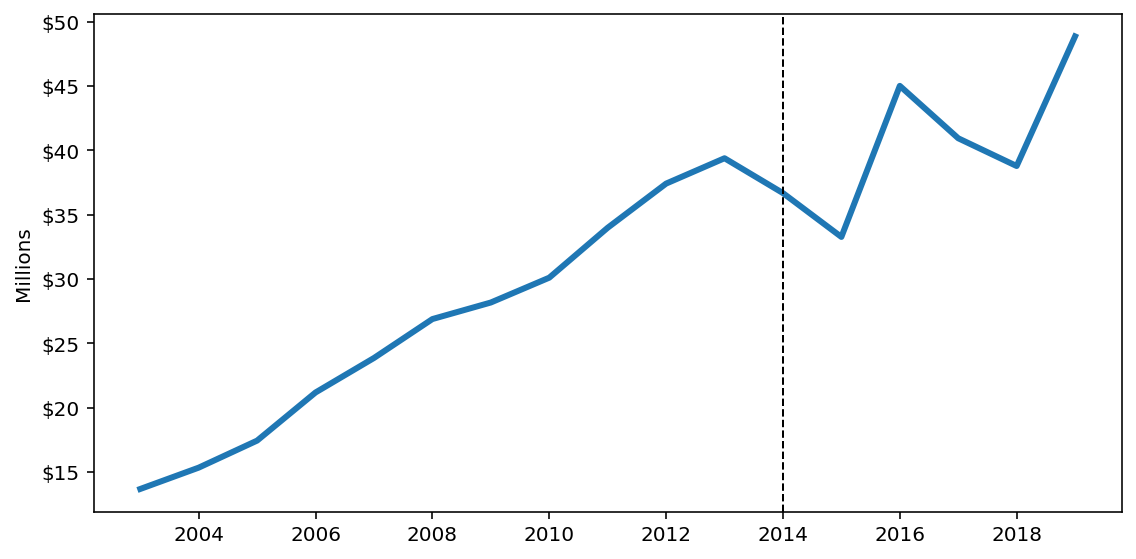

In [74]:
uncomp_care_mean = df_hosp[['year', 'uncomp_care']].groupby('year').mean() / 1000000

data = copy.deepcopy(uncomp_care_mean)
# plot data
fig, ax = plt.subplots(1, 1, figsize=(8,4), sharex=True)
data.plot(subplots=True, ax=ax, linewidth=3)
ax.axvline(2014, color='k', linestyle='dashed', linewidth=1)
# set title and labels
# ax.set_title('Uncompensated Care')
ax.set_ylabel('Millions')
ax.set_xlabel('')
# upgrade axis tick labels
yticks = ax.get_yticks()
ax.set_yticklabels(['${:.0f}'.format(x) for x in yticks])
ax.get_legend().remove()
plt.tight_layout()
plt.savefig('figures/uncomp_care.png', dpi=300)

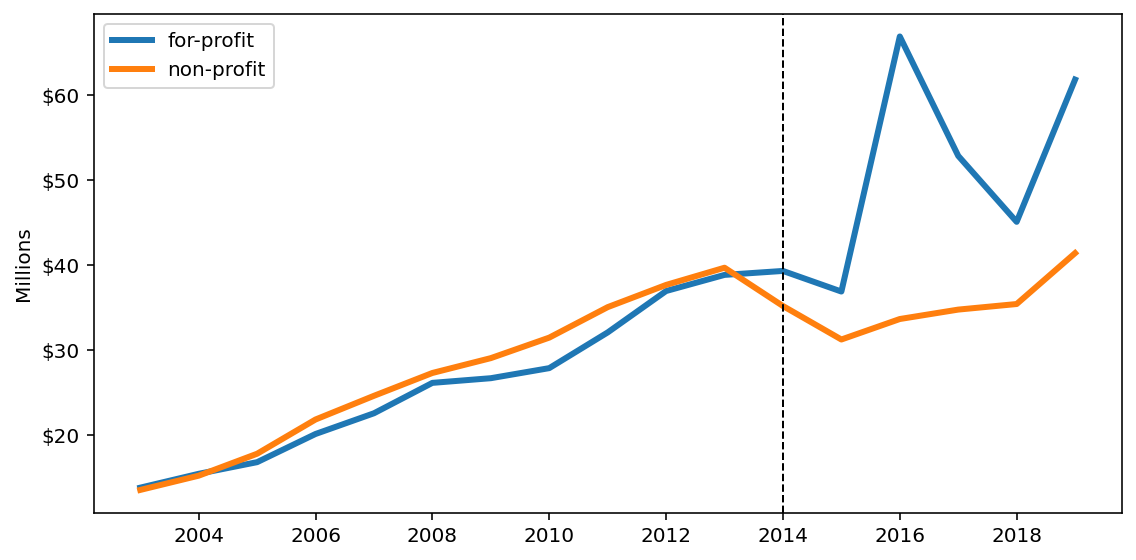

In [75]:
df_hosp_type = df_hosp[(df_hosp['nonprofit']==1) | (df_hosp['forprofit']==1)]
uncomp_care_mean = df_hosp[['year', 'nonprofit', 'uncomp_care']].groupby(['year', 'nonprofit']).mean() / 1000000
uncomp_care_mean = uncomp_care_mean.unstack('nonprofit').droplevel(0, axis=1)
uncomp_care_mean.columns = ['for-profit', 'non-profit']

data = copy.deepcopy(uncomp_care_mean)
# plot data
fig, ax = plt.subplots(1, 1, figsize=(8,4), sharex=True)
data.plot(ax=ax, linewidth=3)
ax.axvline(2014, color='k', linestyle='dashed', linewidth=1)
# set title and labels
# ax.set_title('Uncompensated Care')
ax.set_ylabel('Millions')
ax.set_xlabel('')
# upgrade axis tick labels
yticks = ax.get_yticks()
ax.set_yticklabels(['${:.0f}'.format(x) for x in yticks])
plt.tight_layout()
plt.savefig('figures/uncomp_care_type.png', dpi=300)

In [91]:
df_pos['typ_control'].value_counts()

non-profit private                    3218
for-profit proprietary                3182
non-profit other                      1445
government hosp district/authority    1035
government local                      1009
non-profit church                      745
government state                       514
for-profit phys owned                   94
government federal                      92
government tribal                       11
Name: typ_control, dtype: int64

In [122]:
# plt.figure(figsize=(8, 4))
# plt.plot(uncomp_care_mean, linewidth=3)
# plt.show()

In [121]:
df_hosp_type['typ_control'].value_counts()

non-profit private        38698
for-profit proprietary    25226
non-profit other           8839
non-profit church          6659
for-profit phys owned      1210
Name: typ_control, dtype: int64

In [93]:
df_hosp.to_csv("hospitals_aca.csv", index=False)